In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from progress.bar import Bar

In [29]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [30]:
# dataset prep
def dataset_prep(batch_size):
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])
    train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

    training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return training_DataLoader, testing_DataLoader

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dense1 = nn.Linear(128 * 7 * 7, 256)
        self.dense2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return F.log_softmax(x, dim=1)



In [32]:

def train(model, optimizer, train_loader, device):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss = []
    count = 0

    bar = Bar('Training', max=len(train_loader))

    for i, batch in enumerate(train_loader):
        count += 1
        images, labels = batch[0].to(device), batch[1].to(device)
     
        output = model(images)
        loss = loss_func(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

        bar.next()


    bar.finish()
    train_loss = sum(batch_loss) / count
    acc = 100. * correct / total_samples
    return train_loss, acc


In [33]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    count = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            count +=1
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total_samples += labels.size(0)


    test_loss = sum(test_losses) / count
    accuracy = 100. * correct / total_samples


    return test_loss, accuracy

In [34]:
def sensitivity(model):
    total_norm = 0
    counter = 0
    
    for p in model.parameters():
        if p.grad is not None:
            grad_norm = torch.linalg.norm(p.grad.to(device)).cpu().item()
            total_norm += grad_norm
            counter += 1
    
    if counter == 0:
        return 0
    
    return total_norm / counter

In [36]:
epochs = 16
train_loss_dict = {}
train_acc_dict = {}
test_loss_dict = {}
test_acc_dict = {}
model_state = {}
sensivity_arr = []

for batch_size in [64, 128, 512, 2048, 4096]:
    train_loss_arr = []
    train_acc_arr = []
    test_loss_arr = []
    test_acc_arr = []
    training_DataLoader, testing_DataLoader = dataset_prep(batch_size)
    print(f"For Model with dataset batchsize - {batch_size}")
    model = CNNModel().to(device)
    optimizer1 = optim.SGD(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer1, training_DataLoader, device)
        test_loss, test_acc = test(model, testing_DataLoader)
        print(f'Epoch - {epoch} Train Loss - {train_loss:.6f} Test Loss - {test_loss:.6f} Train Accuracy - {train_acc:.6f} Test Accuracy - {test_acc:.6f}')
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        test_loss_arr.append(test_loss)
        test_acc_arr.append(test_acc)
    key_str = f"model_{batch_size}"
    train_loss_dict[key_str] = train_loss_arr
    train_acc_dict[key_str] = train_acc_arr
    test_loss_dict[key_str] = test_loss_arr
    test_acc_dict[key_str] = test_acc_arr
    model_state[key_str] = model
    sensivity_arr.append(sensitivity(model))

For Model with dataset batchsize - 64
Epoch - 0 Train Loss - 0.416441 Test Loss - 0.144142 Train Accuracy - 88.348333 Test Accuracy - 95.570000
Epoch - 1 Train Loss - 0.119447 Test Loss - 0.086490 Train Accuracy - 96.490000 Test Accuracy - 97.370000
Epoch - 2 Train Loss - 0.081695 Test Loss - 0.065453 Train Accuracy - 97.501667 Test Accuracy - 97.890000
Epoch - 3 Train Loss - 0.064449 Test Loss - 0.047874 Train Accuracy - 98.053333 Test Accuracy - 98.410000
Epoch - 4 Train Loss - 0.054493 Test Loss - 0.044607 Train Accuracy - 98.336667 Test Accuracy - 98.550000
Epoch - 5 Train Loss - 0.048002 Test Loss - 0.044983 Train Accuracy - 98.568333 Test Accuracy - 98.540000
Epoch - 6 Train Loss - 0.042823 Test Loss - 0.032526 Train Accuracy - 98.715000 Test Accuracy - 98.910000
Epoch - 7 Train Loss - 0.037814 Test Loss - 0.061375 Train Accuracy - 98.845000 Test Accuracy - 97.990000
Epoch - 8 Train Loss - 0.035028 Test Loss - 0.029111 Train Accuracy - 98.935000 Test Accuracy - 99.000000
Epoch - 

In [37]:
all_train_loss_arr = []
all_test_loss_arr = []
for item in train_loss_dict.values():
    all_train_loss_arr.append(np.mean(item))
for item in test_loss_dict.values():
    all_test_loss_arr.append(np.mean(item))

In [38]:
all_train_loss_arr

[0.06743533285134812,
 0.10074762896236741,
 0.2469933356505708,
 0.6090462372638286,
 0.9441378636906546]

In [39]:
sensivity_arr

[0.3841788002755493,
 0.3617914372589439,
 0.2171884971903637,
 0.307999232201837,
 0.4305674064671621]

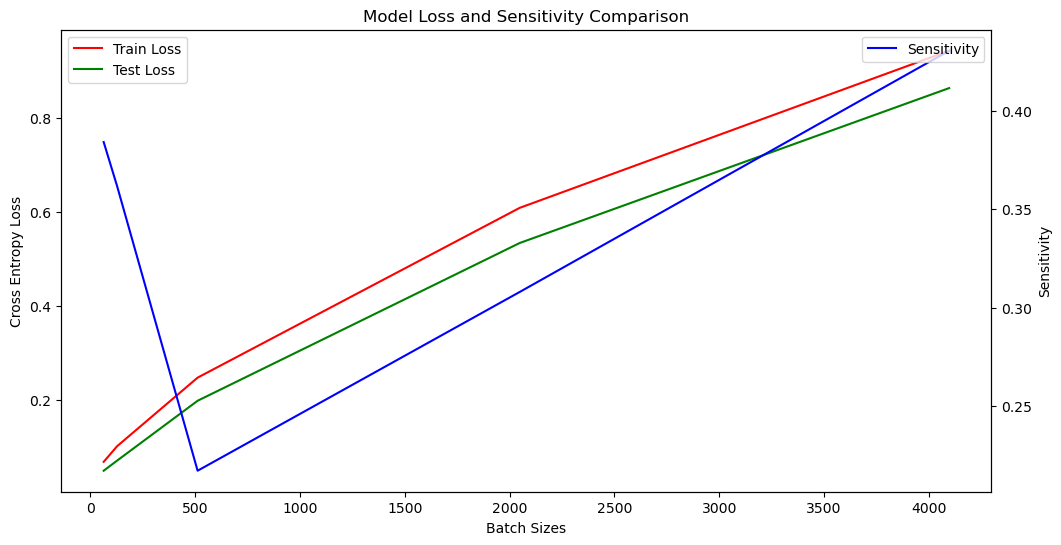

In [40]:
plt.figure(figsize=(12, 6))

plt.plot([64, 128, 512, 2048, 4096], all_train_loss_arr, color="red", label='Train Loss')
plt.plot([64, 128, 512, 2048, 4096], all_test_loss_arr, color="green", label='Test Loss')
plt.xlabel('Batch Sizes')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper left')

ax2 = plt.twinx()
plt.plot([64, 128, 512, 2048, 4096], sensivity_arr, color="blue", label='Sensitivity')
plt.ylabel('Sensitivity')
plt.legend(loc='upper right')

plt.title('Model Loss and Sensitivity Comparison')
plt.xlabel('Batch Sizes')

plt.show()

In [41]:

all_train_acc_arr = []
all_test_acc_arr = []
for item in train_acc_dict.values():
    all_train_acc_arr.append(np.mean(item))
for item in test_acc_dict.values():
    all_test_acc_arr.append(np.mean(item))

In [42]:
all_train_acc_arr, all_test_acc_arr


([98.02447916666667,
  97.11052083333333,
  93.39322916666666,
  85.5878125,
  79.44968750000001],
 [98.383125, 97.86625000000001, 94.06625, 88.370625, 82.94125000000001])

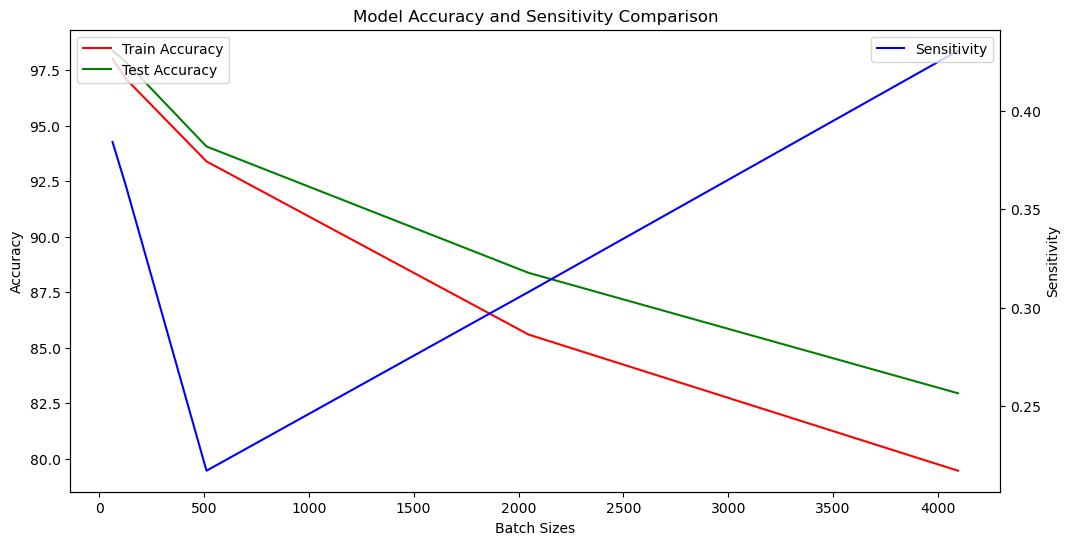

In [43]:
plt.figure(figsize=(12, 6))
plt.plot([64, 128, 512, 2048, 4096], all_train_acc_arr, color="red", label='Train Accuracy')
plt.plot([64, 128, 512, 2048, 4096], all_test_acc_arr, color="green", label='Test Accuracy')
plt.xlabel('Batch Sizes')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

ax2 = plt.twinx()
plt.plot([64, 128, 512, 2048, 4096], sensivity_arr, color="blue", label='Sensitivity')
plt.ylabel('Sensitivity')
plt.legend(loc='upper right')

plt.title('Model Accuracy and Sensitivity Comparison')

plt.show()